In [44]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt

# Math operations
import numpy as np

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [19]:
def create_X_Y(ts: np.array, lag=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[(i + lag):(i + lag), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [20]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)
    

In [39]:
df = pd.read_csv('values_normalized.csv')
df = df.dropna()
ts = df[[
'huss', 
'f107', 
'siconc', 
'kp', 
'ap', 
'iprp', 
'ssn',
'tsi',
'scnum',
'iprm',
'iprg',
'scph',
'tas'
]].values
X, Y = create_X_Y(ts, lag=500, target_index=slice(0, 13))
n_ft = X.shape[2]

In [40]:
# Number of lags (hours back) to use for models
lag = 500
# Share of obs in testing 
test_share = 0.15
# Epochs for training
epochs = 10
# Batch size 
batch_size = 256
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 10

In [41]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [42]:
# Load model from file
import keras.models
saved_model = keras.models.load_model("lstm 1000")
deep_learner = NNMultistepModel(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=13,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch_size,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Training of the model 
deep_learner.model = saved_model
model = deep_learner

In [52]:
# Initiating the model object
model = NNMultistepModel(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=13,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch_size,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Training of the model 
history = model.train()


Epoch 1/10
68/68 [==============================] - 11s 145ms/step - loss: 2994567643136.0000 - val_loss: 0.3216
Epoch 2/10
68/68 [==============================] - 9s 139ms/step - loss: 0.2316 - val_loss: nan
Epoch 3/10
68/68 [==============================] - 10s 142ms/step - loss: 0.1905 - val_loss: nan
Epoch 4/10
68/68 [==============================] - 10s 145ms/step - loss: 0.1704 - val_loss: nan
Epoch 5/10
68/68 [==============================] - 10s 144ms/step - loss: 0.1591 - val_loss: nan
Epoch 6/10
68/68 [==============================] - 9s 139ms/step - loss: 0.1531 - val_loss: 0.1931
Epoch 7/10
68/68 [==============================] - 10s 142ms/step - loss: 0.1489 - val_loss: 0.1844
Epoch 8/10
68/68 [==============================] - 10s 143ms/step - loss: 0.1454 - val_loss: 0.1793
Epoch 9/10
68/68 [==============================] - 10s 143ms/step - loss: 0.1425 - val_loss: 0.1755
Epoch 10/10
68/68 [==============================] - 10s 146ms/step - loss: 0.1400 - val_loss

In [53]:
# Comparing the forecasts with the actual values
yhat = [x for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [61]:
# Predict n days ahead
n_ahead = 200
yhat=[]
Xn = Xval[-lag:]
for i in range(n_ahead):
    print(i)
    fc = model.predict(Xn)
    yhat.append(fc[0][-1])  # Append next temp to yhat
    Xn = np.delete(Xn, slice(0, 1*lag*X.shape[2]))
    Xn = np.append(Xn, fc)
    Xn = np.reshape(Xn, (lag, lag, X.shape[2]))

print(yhat)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[0.6654984, 0.6643382, 0.65820926, 0.65334135, 0.65037715, 0.6532723, 0.65687734, 0.65996706, 0.65968245, 0.6571276, 0.65533155, 0.6576732, 0.6596626, 0.6564047, 0.65587395, 0.6565131, 0.65500146, 0.6523856, 0.6481168, 0.64514923, 0.643754, 0.6471553, 0.64590484, 0.64860076, 0.64580005, 0.6470842, 0.6490477, 

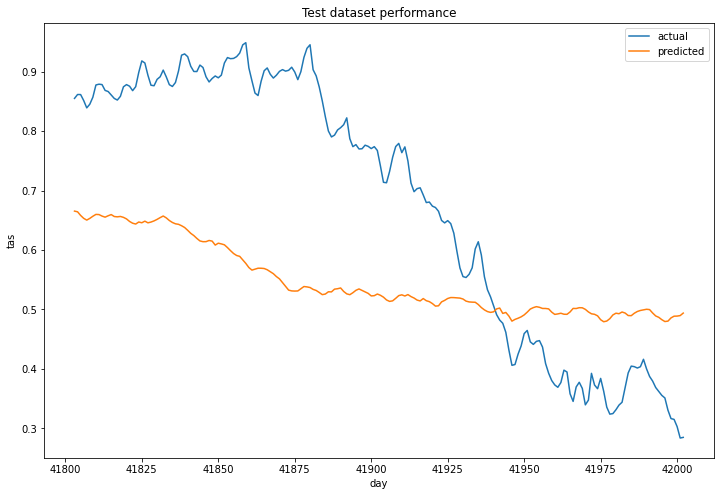

In [62]:
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
plt.figure(figsize=(12, 8))
plt.plot(fc['day'], fc['tas'], label='actual')
plt.plot(fc['day'], fc['forecast'], label='predicted')
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Test dataset performance")
plt.legend()
plt.show()